Accuracy: 0.9333333333333333


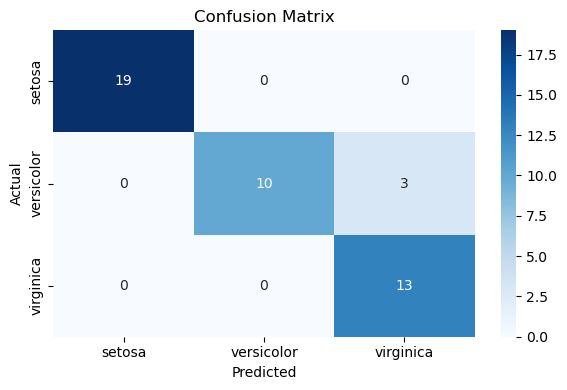

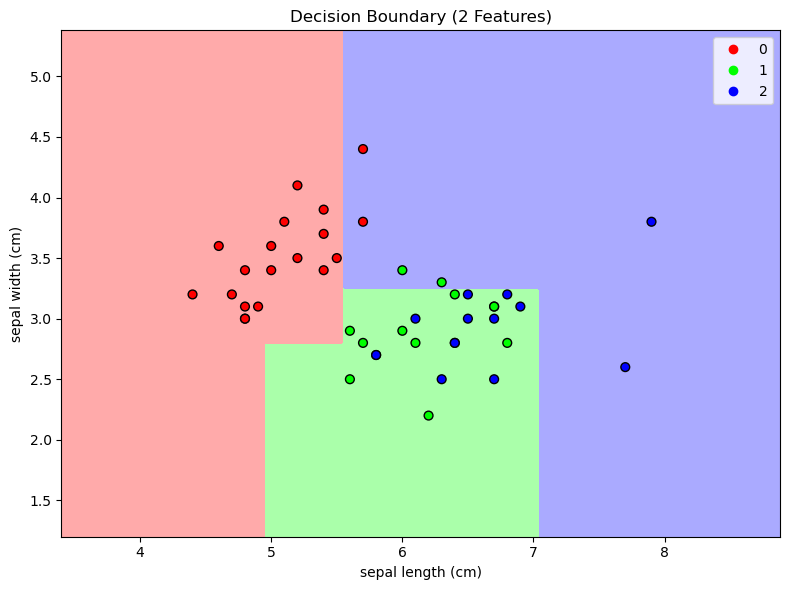

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None
        parent_entropy = self._entropy(y)
        best_gain = 0
        split_idx, split_thresh = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes
            num_right = np.bincount(classes, minlength=self.n_classes)
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                entropy_left = self._entropy_from_counts(num_left)
                entropy_right = self._entropy_from_counts(num_right)
                p_left = i / m
                p_right = 1 - p_left
                gain = parent_entropy - (p_left * entropy_left + p_right * entropy_right)
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gain > best_gain:
                    best_gain = gain
                    split_idx = idx
                    split_thresh = (thresholds[i] + thresholds[i - 1]) / 2
        return split_idx, split_thresh

    def _entropy_from_counts(self, counts):
        total = sum(counts)
        return -sum((count / total) * np.log2(count / total) for count in counts if count != 0)

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(value=predicted_class)

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                if len(X_left) > 0 and len(X_right) > 0:
                    node.feature = idx
                    node.threshold = thr
                    node.left = self._grow_tree(X_left, y_left, depth + 1)
                    node.right = self._grow_tree(X_right, y_right, depth + 1)
                    return node
        return node

    def _predict(self, inputs):
        node = self.root
        while node.left:
            if inputs[node.feature] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTree(max_depth=3)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

def plot_decision_boundary(tree, X, y, feature_names, h=0.02):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = np.array(Z).reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Boundary (2 Features)")
    handles, labels = scatter.legend_elements()
    plt.legend(handles=handles, labels=labels)
    plt.tight_layout()
    plt.show()

X_train_2D = X_train[:, :2]
X_test_2D = X_test[:, :2]
tree2D = DecisionTree(max_depth=3)
tree2D.fit(X_train_2D, y_train)

plot_decision_boundary(tree2D, X_test_2D, y_test, feature_names=data.feature_names[:2])
